In [1]:
import torch
import numpy as np
from fairseq import utils, tasks
from fairseq import checkpoint_utils
from utils.eval_utils import eval_step
from tasks.mm_tasks.caption import CaptionTask
from models.ofa import OFAModel
from PIL import Image

# Register refcoco task
tasks.register_task('caption', CaptionTask)

# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()
# use_cuda = False
# use fp16 only when GPU is available
use_fp16 = False

2022-10-07 21:46:30 | INFO | torch.distributed.nn.jit.instantiator | Created a temporary directory at /tmp/tmp1reuq7aj
2022-10-07 21:46:30 | INFO | torch.distributed.nn.jit.instantiator | Writing /tmp/tmp1reuq7aj/_remote_module_non_scriptable.py


In [2]:
# Load pretrained ckpt & config
overrides={"eval_cider":False, "beam":5, "max_len_b":16, "no_repeat_ngram_size":3, "seed":7}
models, cfg, task = checkpoint_utils.load_model_ensemble_and_task(
        utils.split_paths('checkpoints/caption.pt'),
        arg_overrides=overrides
    )

# Move models to GPU
for model in models:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

# Initialize generator
generator = task.build_generator(models, cfg.generation)

2022-10-07 21:46:46 | INFO | tasks.ofa_task | source dictionary: 59457 types
2022-10-07 21:46:46 | INFO | tasks.ofa_task | target dictionary: 59457 types
/mnt/d/dataset/Adult/OFA/.venv/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/mnt/d/dataset/Adult/OFA/.venv/lib/python3.8/site-packages/torch/cuda/__init__.py:146: UserWarning: 
NVIDIA GeForce RTX 3090 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arc

# Preprocess

In [3]:
# Image transform
from torchvision import transforms
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose(
    [
        lambda image: image.convert("RGB"),
        transforms.Resize((cfg.task.patch_image_size, cfg.task.patch_image_size), interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()
def encode_text(text, length=None, append_bos=False, append_eos=False):
    s = task.tgt_dict.encode_line(
        line=task.bpe.encode(text),
        add_if_not_exist=False,
        append_eos=False
    ).long()
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s])
    if append_eos:
        s = torch.cat([s, eos_item])
    return s

# Construct input for caption task
def construct_sample(image: Image):
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])
    src_text = encode_text(" what does the image describe?", append_bos=True, append_eos=True).unsqueeze(0)
    src_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in src_text])
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": src_text,
            "src_lengths": src_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask
        }
    }
    return sample
  
# Function to turn FP32 to FP16
def apply_half(t):
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

/tmp/ipykernel_31694/2956580135.py:9: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  transforms.Resize((cfg.task.patch_image_size, cfg.task.patch_image_size), interpolation=Image.BICUBIC),
/mnt/d/dataset/Adult/OFA/.venv/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [4]:
! wget https://huggingface.co/spaces/OFA-Sys/OFA-Image_Caption/resolve/main/donuts.jpg
! mv donuts.jpg ./test.jpg


--2022-10-07 21:46:55--  https://huggingface.co/spaces/OFA-Sys/OFA-Image_Caption/resolve/main/donuts.jpg
Resolving huggingface.co (huggingface.co)... 54.210.225.113, 52.5.54.249, 44.195.102.200, ...
Connecting to huggingface.co (huggingface.co)|54.210.225.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 364034 (356K) [image/jpeg]
Saving to: ‘donuts.jpg’

donuts.jpg          100%[===================>] 355.50K   490KB/s    in 0.7s    

2022-10-07 21:46:57 (490 KB/s) - ‘donuts.jpg’ saved [364034/364034]



In [5]:
!wslpath "D:\dataset\Adult\adult_crawler\scripts\dataset.xlsx"

/mnt/d/dataset/Adult/adult_crawler/scripts/dataset.xlsx


In [6]:
# Construct input sample & preprocess for GPU if cuda available
import random
from torchvision.transforms import functional as F
from torchvision.transforms import InterpolationMode

from pathlib import Path

image_root_dir = Path("/mnt/d/dataset/Adult/adult_crawler/docker/minio/data")
dataset_file = Path("/mnt/d/dataset/Adult/adult_crawler/scripts/dataset.xlsx")


In [7]:
!pip install openpyxl
!pip install ipywidgets

In [8]:
import pandas  as pd
df = pd.read_excel(dataset_file)

In [9]:
df["name"].unique()

array(['EroG', 'OtakaraShogunate', 'PornPics'], dtype=object)

In [10]:
id_dict = {
    "EroG": "ero-g",
    "OtakaraShogunate": "otakara-shogunate",
    "PornPics": "porn-pics",
}

In [11]:
from tqdm import tqdm

for i in tqdm(list(range(20))):
    pass

100%|██████████| 20/20 [00:00<00:00, 184365.01it/s]


In [12]:
df.loc[i, "image"]

'/57ce4e1a-22ea-5c42-bc4e-2c8cb8d4c11e/5b8cf731-519c-5799-b70f-9136e5c9d90c.jpg'

In [20]:
# Run eval step for caption
from utils.eval_utils import eval_caption
from tqdm import tqdm

df["ofa_caption"] = pd.NA

with torch.no_grad():
    for i in tqdm(df.index):
        file = image_root_dir / id_dict[df.loc[i, "name"]] / df.loc[i, "image"][1:]
        try:
            image = Image.open(file)

            sample = construct_sample(image)
            sample = utils.move_to_cuda(sample) if use_cuda else sample
            sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

            result, scores = eval_caption(task, generator, models, sample)

            df.loc[i, "ofa_caption"] = result[0]['caption']
        except RuntimeError as e:
            raise e
        except Exception as e:
            df.loc[i, "ofa_caption"] = pd.NA
            continue

  0%|          | 1/607999 [00:00<18:21:20,  9.20it/s]


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [19]:


sample = construct_sample(image)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

result, scores = eval_caption(task, generator, models, sample)


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

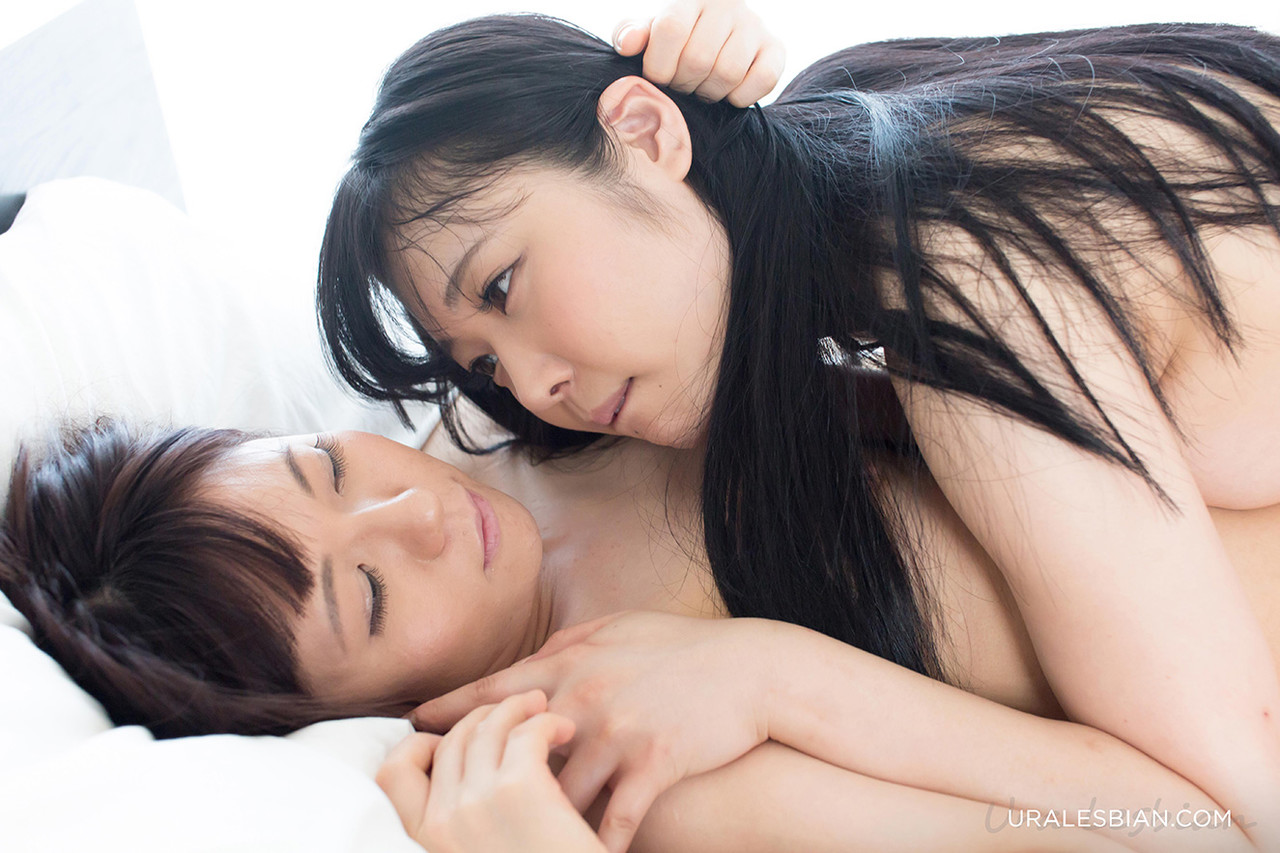

NameError: name 'result' is not defined

In [15]:
display(image)
print('Caption: {}'.format(result[0]['caption']))